# CS 109A
## Milestone 3

### Colleen Driscoll, Oliver Mayor and Pooja Tyagi
### 28 November 2018

## Progress Summary

In Milestone 3, we present the results of exploratory data analysis with respect to U.S. House of Representative elections since 1990, dependent on data availability. 

Because results for the 2018 election are not yet finalized ([some districts have not yet finished counting](https://www.cnn.com/2018/11/28/politics/why-california-is-still-counting-ballots/index.html)), we report base model results to 'predict' the results of the 2016 election. 

---
### Research Question: Which candidates will be elected to the U.S. House of Representatives in 2018?

To address this question, the team has accumulated economic, social, and political data on U.S. Congressional Districts and the representatives elected from them. To train accurate models, this data has been collected for the past several decades, based on what is readily available. 

### Data Summary

**Political Outcomes**

- As our main outcome of interest, we aim to predict which candidate will win the election for each of the 435 races for Congress. Simplifying this, without loss of generality, we model whether the *Democratic* candidate in each district will win; additionally, the two-party nature of politics allows us to operationalize the binary outcome as one where we predict that the Democrat candidate will win the election if her odds of winning are greater than those of the Republican candidate (that is, if the log-odds is greater than zero). In training datasets, if the Democratic proportion of the two-party vote is greater than 0.5, then the Democrat candidate wins. (Note: There have been a handful of independent members of the House of Representatives of 435 \[no more than two per term\]. However, as all of the top candidates 2018 election were either Democrats or Republicans, it is safe to ignore third parties/independent candidates in our analysis). 
- **Data sources:** 
    * 2018 election: As of writing, the results of at least one Congressional district have not yet been finalized; upon the certification of all results, the test set data will be compiled either from official state election boards or downloaded from other academics/media.
    * 1980 - 2016 outcomes: Data collected based on official records by the [Constituency-Level Elections Archive](http://www.electiondataarchive.org/). Following the modeling plan outlined above, we calculated the Democratic share of the two-party vote for each district across 19 elections. 

**Political Explanatory Variables**
- Candidate data
   * Incumbency status:  [Much research in political science](https://www.jstor.org/stable/2111475) has shown the large positive effect on a candidate's chances of being elected if she is the current holder of the seat (the incumbent). Taking this into account, we create a binary variable for whether the incumbent is running in the election. Next, we combine this binary variable with another that indicates whether the incumbent is a Democrat or Republican, forming an interaction term. When the interaction term indicates that there is a Democratic incumbent running for re-election, we expect predicted Democratic vote share to be higher. When there is a Republican incumbent running for re-election, we expect Democratic vote share to be lower.
   * Ideological position(s): Political scientists have developed techniques to estimate the ideological position of elected representatives, especially those in Congress. [Poole and Rosenthal](https://voteview.com/about) have developed DW-NOMINATE (Dynamic Weighted NOMINAl Three-step Estimation) scores, which are an aggregate measure of a Congressmember's lifetime public voting record in office over two dimensions, which broadly reflect differences in preferences on economic and social policy. We also include the [Nokken-Poole score](https://onlinelibrary.wiley.com/doi/abs/10.3162/036298004X201294), which does not make assumptions about ideological stability in members of Congress over time, allowing for more fluctuations within the same legislator over time. Both measures provide for different understandings of the ideology of the incumbent (essentially, how long a memory constituents have); thus, we include both in our dataset.

- Contextual data
    * District prior vote share: For each district, we have a long record of voting. It is likely the case that a district's partisanship, as measured by its most recent vote results, predicts the next future results very well. However, politics is cyclical and all data is subject to random variation. Thus, we include results from multiple years prior to 2018 to train the model. A potential issue with this is the changing nature of districts over time due to redrawing of district boundaries (redistricting). In the next Milestone, we will have a systematic method to deal with redistricting, based on weighting results from districts that once composed the current district. 

**Socio-economic Data**

In the next Milestone, we present data from the [American Community Survey](census.gov). There, we obtain variables on median district age, unemployment rate, household income, educational attainment, and racial/ethnic backgrounds. Regression results using these covariates are not presented at this stage; however, summary statistics are, and these variables will be incorporated in the final model to maximize predictive power. 


In [8]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import os

In [9]:
data_folder = "https://raw.githubusercontent.com/cdriscoll92/CS-109A-Final-Project/master/data/"
# local_data_folder = '/Users/poojatyagi/Dropbox (MIT)/CS 109A Final project/Data'
local_data_folder = "/Users/colleendriscoll/Dropbox/Classes/CS 109A/CS 109A Final project/data/"

In [10]:
## Reading in state abbreviations file to get the correct district ID columns
state_abbs = pd.read_csv(data_folder + "state_abbreviations_correspondence_table.csv")

Reading in and cleaning data from the [Constituency-Level Elections Archive](http://www.electiondataarchive.org/):

In [11]:
## Grouping CLEA by district-year to get the 
## democratic share of the two-party vote
def group_to_D_vote(groupby_obj, democrat_code):
    ## Groupby object with "yr", "dist_id", "pty", ""
    years = []
    dist_ids = []
    dem_shares = []
    
    for name, group in groupby_obj:
        dem_share = 0
        years.append(group.yr.values[0])
        dist_ids.append(group.dist_id.values[0])

        if democrat_code in group.pty.values: ## If a Democrat ran
            total_votes = np.sum(group.cv1.values)
            dem_votes = np.sum(group.cv1[group.pty == democrat_code].values)
            dem_share = dem_votes/total_votes
        dem_shares.append(dem_share)
    
    dem_vote_share_dict = {'year': years,
                           'dist_id': dist_ids,
                           'dem_vote_share': dem_shares
                          }
    return(dem_vote_share_dict)


def clea_clean(clea_file_name, state_abb_df):
    ## Read in data
    clea_results = pd.read_csv(clea_file_name)
    democrat_code = 180
    republican_code = 583
    election_month_int = 11
    
    ## Subsetting to only Democrats and Republicans
    clea_results = clea_results[(clea_results.pty == democrat_code) | 
                                (clea_results.pty == republican_code)]
    ## Only general elections (November)
    clea_results = clea_results[clea_results.mn == election_month_int]

    ## Extracting district number from constituency name
    ## There are some states with only one district that then don't 
    ## have a district number listed -- therefore filling those NAs with 1s
    clea_results['dist_num'] = clea_results.cst_n.str.findall('[0-9]+').\
    str[0].fillna(1)
    
    ## Lowercase state name to match CLEA listing
    state_abb_df['state_name_lower'] = state_abb_df.state_name.str.lower()

    ## Merging CLEA with state abbrevation correspondence table
    clea_merged = pd.merge(clea_results, state_abb_df,
                              how = 'right',
                              left_on = 'sub',
                              right_on = 'state_name_lower')
    
    ## Creating distict ID variable to merge on later
    clea_merged['dist_id'] = clea_merged['state_abb']+ "_" + \
    clea_merged['dist_num'].astype(str)

    ## Grouping CLEA by district-year to get the democratic share of the 
    ## two-party vote
    grouped = clea_merged.groupby(['dist_id', 'yr'])
    
    dem_vote_share = pd.DataFrame(group_to_D_vote(grouped, 
                                                 democrat_code))
    
    return dem_vote_share

In [12]:
clea_cleaned = clea_clean(data_folder + "election_results/clea_20180507.csv",
                          state_abbs)
clea_cleaned[:5]

,year,dist_id,dem_vote_share
0,1980,AK_1,0.259215
1,1982,AK_1,0.288493
2,1984,AK_1,0.431049
3,1986,AK_1,0.421110
4,1988,AK_1,0.373454


In [13]:
results_2018_df = pd.read_csv(local_data_folder + 
                           "election_results/2018_scraped_cleaned.csv")
results_2018_df[:5]

,dist_id,pty,cv1,yr
0,AL_1,D,88365,2018
1,AL_2,D,86580,2018
2,AL_3,D,83145,2018
3,AL_4,D,46370,2018
4,AL_5,D,99694,2018


In [14]:
grouped_2018 = results_2018_df.groupby(['dist_id', 'yr'])
results_2018_with_year = pd.DataFrame(group_to_D_vote(grouped_2018, "D"))
results_2018_with_year[:5]

,year,dist_id,dem_vote_share
0,2018,AK_1,0.458323
1,2018,AL_1,0.367158
2,2018,AL_2,0.384525
3,2018,AL_3,0.360520
4,2018,AL_4,0.201322


In [15]:
results_2018 = results_2018_with_year.drop("year",
                                           axis = 1,
                                           inplace = False)
results_2018.columns = ['dist_id', 'dem_vote_share_2018']
## If Democratic vote share is >0.50, the Democrat won; else
## the Republican did
results_2018['dem_won_2018'] = np.round(results_2018.dem_vote_share_2018, 0)

In [16]:
# results_2018[20:25]
## Rbind
clea_cleaned = pd.concat([clea_cleaned, results_2018_with_year])

In [17]:
## Merging in the 2018 data to the covariate dataset
clea_cleaned = pd.merge(clea_cleaned, results_2018,
                       on = "dist_id", how = "left")

In [18]:
clea_cleaned[:5]

,year,dist_id,dem_vote_share,dem_vote_share_2018,dem_won_2018
0,1980,AK_1,0.259215,0.458323,0.0
1,1982,AK_1,0.288493,0.458323,0.0
2,1984,AK_1,0.431049,0.458323,0.0
3,1986,AK_1,0.421110,0.458323,0.0
4,1988,AK_1,0.373454,0.458323,0.0


NOMINATE Data summary

In [19]:
def drop_secondary_members(nominate_df):
    ## Districts where there was more than one member of Congress serving, 
    ## assign the one who voted the most number of times to the district
    multiple_member_districts = nominate_df.dist_id\
    [nominate_df.dist_id.duplicated()]
    
    nominate_df['main_member'] = 1
    for district in multiple_member_districts:
        member_votes = nominate_df.nominate_number_of_votes\
        [nominate_df.dist_id == district]

        orders = np.argsort(member_votes)

        lowest_score_index = nominate_df['main_member']\
        [nominate_df.dist_id == district][orders == 0].index

        nominate_df.loc[lowest_score_index, 'main_member'] = 0

    ## Only keeping the main member in each district
    nominate_df = nominate_df[nominate_df.main_member == 1]
    nominate_df.drop('main_member', axis = 1, inplace = True)

    return nominate_df

def nom_scores_clean(nom_file_name, cols_keep):
    nominate_scores = pd.read_csv(nom_file_name)
    nominate_scores = nominate_scores[cols_keep]
    
    ## Dropping president
    nominate_scores = nominate_scores[nominate_scores['state_abbrev']\
                                      != "USA"]

    ## Dropping members who didn't vote (they can't provide ideology measures then)
    missing_vote_num_indices = nominate_scores.nominate_number_of_votes.isna()\
    == True
    nominate_scores = nominate_scores[~missing_vote_num_indices]

    ## District ID column
    nominate_scores['dist_id'] = nominate_scores.state_abbrev + '_' + \
    nominate_scores.district_code.astype(str)

    nominate_scores = drop_secondary_members(nominate_scores)

    nominate_scores.drop('nominate_number_of_votes', axis = 1,
                        inplace = True)

    ## Election year during which this Congress was in session (not the one that
    ## produced this Congress!)
    session_length = 2
    congress_start_year = 1788
    nominate_scores['year'] = congress_start_year + session_length*\
    nominate_scores['congress']

    return nominate_scores

In [20]:
session_nums = ['096', '097', '098', '099', '100', '101', '102', '103', '104',
                '105', '106', '107', '108', '109', '110', '111', '112', '113',
                '114', '115']

nominate_csvs = [data_folder + "nominate_scores/H" + x + "_members.csv" \
                 for x in session_nums]

In [21]:
nom_cols_keep = ['congress', 'icpsr', 'district_code',
                'state_abbrev', 'party_code', 'bioname', 'born',
                'nominate_dim1', 'nominate_dim2','nominate_number_of_votes',
                'nokken_poole_dim1', 'nokken_poole_dim2']

In [22]:
nom_combined = nom_scores_clean(nominate_csvs[0],
                                nom_cols_keep)

for file_path in nominate_csvs[1:]:
    df = nom_scores_clean(file_path, nom_cols_keep)
    nom_combined = nom_combined.append(df, ignore_index = True)
    

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [23]:
merged_elections_ideology = pd.merge(clea_cleaned, nom_combined, how = "left", 
                                     on = ["year", "dist_id"])
merged_elections_ideology['age'] = merged_elections_ideology['year'] - \
merged_elections_ideology['born']

merged_elections_ideology['dem_incumbent'] = 0
merged_elections_ideology['dem_incumbent'][merged_elections_ideology.party_code == 100] = 1
merged_elections_ideology.drop(['district_code','state_abbrev',
                               'bioname', 'born', 'party_code'],
                               axis = 1, inplace = True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
merged_elections_ideology[2000:2005]

,year,dist_id,dem_vote_share,dem_vote_share_2018,dem_won_2018,congress,icpsr,nominate_dim1,nominate_dim2,nokken_poole_dim1,nokken_poole_dim2,age,dem_incumbent
2000,2014,GA_1,0.390865,0.420421,0.0,113.0,29338.0,0.540,0.302,0.690,-0.059,59.0,0
2001,2016,GA_1,0.000000,0.420421,0.0,114.0,21513.0,0.572,0.370,0.551,0.272,59.0,0
2002,1980,GA_10,0.802200,0.370634,0.0,96.0,14404.0,-0.028,0.639,-0.063,0.675,58.0,1
2003,1982,GA_10,1.000000,0.370634,0.0,97.0,14404.0,-0.028,0.639,-0.025,0.838,60.0,1
2004,1984,GA_10,1.000000,0.370634,0.0,98.0,14404.0,-0.028,0.639,-0.003,0.631,62.0,1


In [25]:
["test"+str(i) for i in range(7)]


['test0', 'test1', 'test2', 'test3', 'test4', 'test5', 'test6']

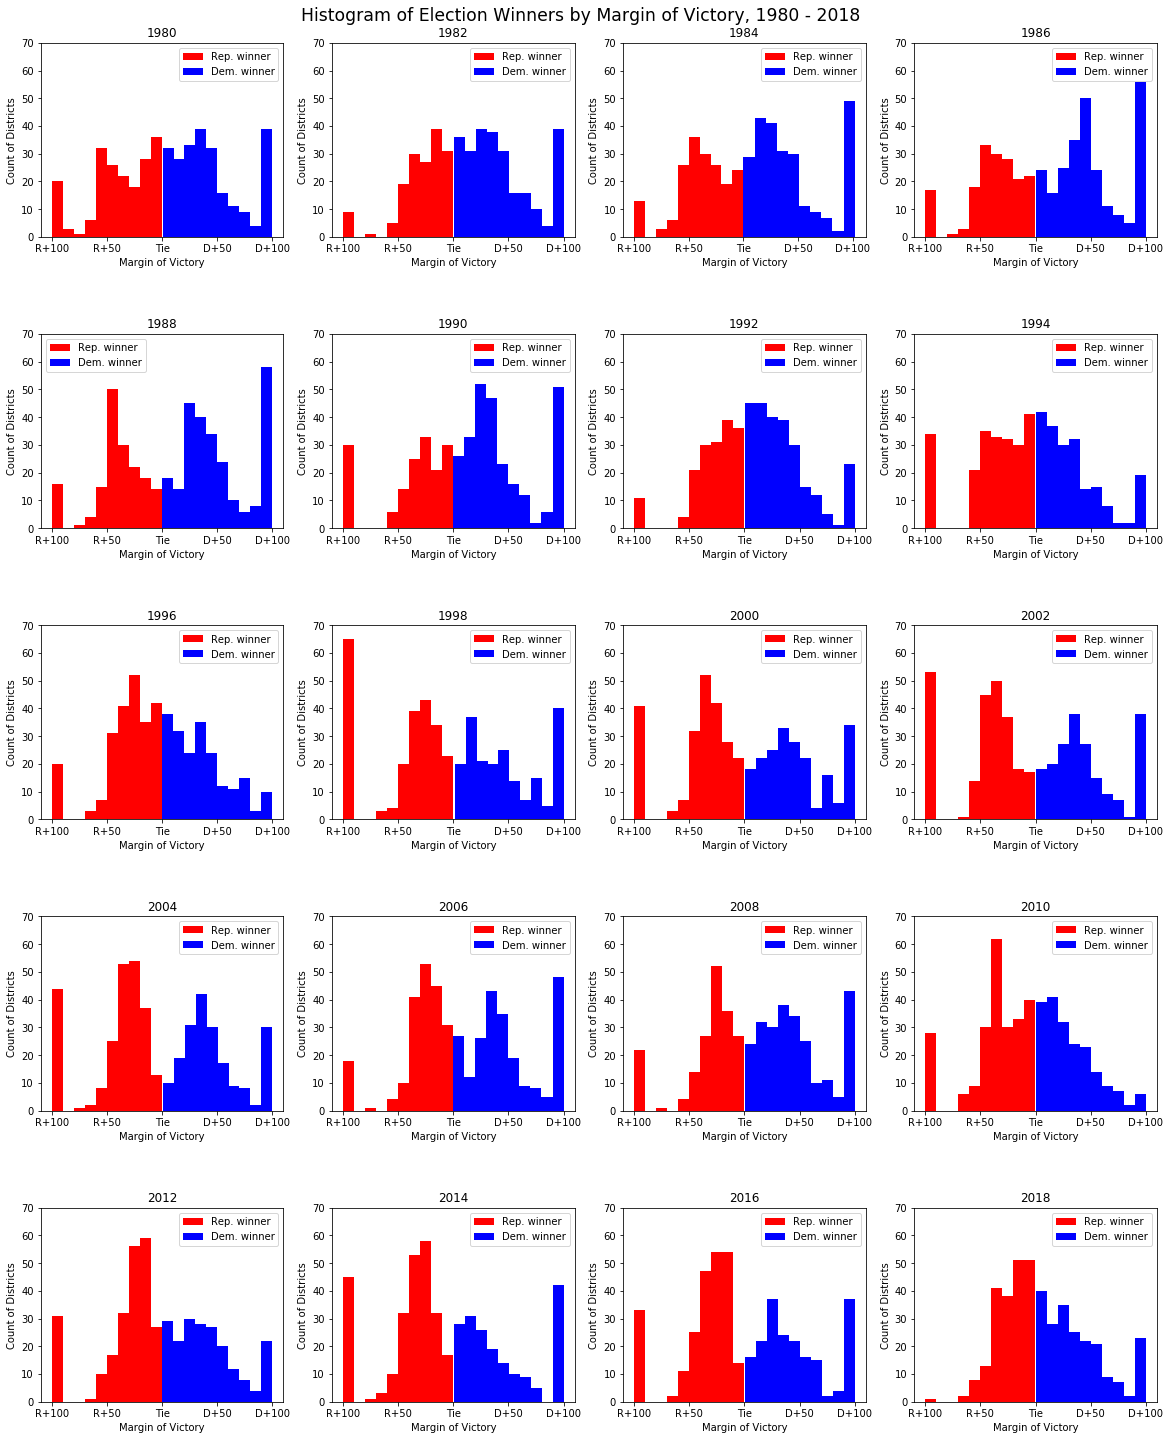

In [27]:
col_n, row_n = 4,5

fig, ax  = plt.subplots(nrows=row_n, ncols=col_n, figsize=(5*col_n,5*row_n))
fig.suptitle("Histogram of Election Winners by Margin of Victory, 1980 - 2018",
            y = 0.9, fontsize = "xx-large")
fig.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.2, hspace=0.5)
ax = ax.flatten()
for i, year in enumerate(merged_elections_ideology.year.unique()):
    histogram_values = merged_elections_ideology.dem_vote_share[
        merged_elections_ideology.year == year].values
    republican_winners = [x for x in histogram_values if x < 0.5]
    democrat_winners = [x for x in histogram_values if x >= 0.5]
    ax[i].hist(republican_winners, color = "red",
                           label = "Rep. winner")
    ax[i].hist(democrat_winners, color = "blue",
                           label = "Dem. winner")
    ax[i].set_ylim(0, 70)
    ax[i].set_title(year)
    ax[i].set_xlabel("Margin of Victory")
    ax[i].set_ylabel("Count of Districts")
    ax[i].set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax[i].set_xticklabels(["R+100", "R+50", "Tie","D+50","D+100"])
    ax[i].legend()
plt.show();



Above, we see the proportion of votes given to the Democratic candidate in each district since 1980. If the Democratic share of the vote is over 50%, then by American electoral rules, the Democrat wins the election (blue shaded bars). If the Democratic share of the vote is below 50%, then the Republican share is over 50%, given the American two-party system, so the Republican candidate wins.

One striking element of the figure above is the number of extreme values at 0 and 1, which indicate candidates that run unopposed. The number of candidates that ran unopposed seems to be highest between 1998 and 2004, although has remained high over the range of years available. Obviously, if a candidate runs unopposed, predicting the outcome is trivial.

Finally, the margins of victory are worth noting. While many margins of victory were small in 1980 (there are many observations in the range (0.4, 0.6), 2004 provides an example of well-divided elections, whose result was very clear. That said, there does not appear to be a pattern in when the results will be well-separated across the two parties; such distinctions could be made through more thorough analysis of more covariates.

In [28]:
ntl_df = pd.read_csv(data_folder + "national_government_makeup.csv")

In [29]:
## Merging it into the merged_elections_ideology dataset

In [30]:
## Years in which there was a Republican/Democratic President
R_pres_year_ranges = [[1980.1,1992], [2000.1, 2008], [2016.1, 2018]]
D_pres_year_ranges = [[1978, 1980], [1992.1,2000], [2008.1, 2016]]

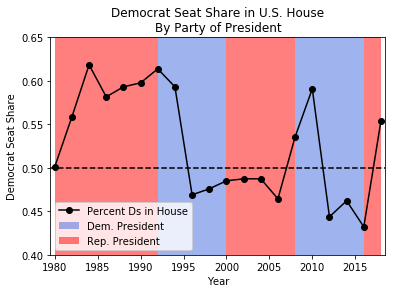

In [31]:
year_low, year_high = 1980, 2018
x = np.arange(year_low, year_high+2, 2)

fig, ax = plt.subplots()
ax.plot(ntl_df.year.values,ntl_df.house.values, "o-",
       color = "black",
       label = "Percent Ds in House")
ax.axhline(0.5, color = "black", linestyle = "--")
ax.set_xlim(year_low-0.5, year_high+0.5)
ax.set_ylim(0.4, 0.65)
## Republican presidents
for year_range in R_pres_year_ranges:
    ax.fill_between(x, 0.7, where = (x > year_range[0] - 1) &
                    (x < year_range[1] + 1),
                    facecolor = "red",
                   alpha = 0.5)
## Democrat presidents
for year_range in D_pres_year_ranges:
    ax.fill_between(x, 0.7, where = (x > year_range[0] - 1) &
                    (x < year_range[1]+1),
                    facecolor = "royalblue",
                   alpha = 0.5)
ax.fill_between(x, 0, facecolor = "royalblue", alpha =0.5,
               label = "Dem. President")
ax.fill_between(x, 0, facecolor = "red", alpha =0.5,
               label = "Rep. President")
plt.title("Democrat Seat Share in U.S. House\nBy Party of President")
plt.xlabel("Year")
plt.ylabel("Democrat Seat Share")
plt.legend()
plt.show();

Above, we see the percent seats held by Democrats in the House over time and under Presidents from different parties. This plot shows the midterm advantage enjoyed by the non-presidential party in American politics -- at midterm elections (two years after the President was (re)elected), voters tend to support the party in opposition. This is seen in the graph above by steep drop-offs in the proportion of House seats held be Democrats 1994-1996 and 2008-2010. Additionally, Republicans lost a large share of seats 1982-1984 and 2006-2008.

In terms of modeling, this suggests that we should include a dummy variable indicating whether the election was a Presidential or midterm election. Given that the 2018 election is a midterm election under a Republican President, we expect the Democratic Party (the opposition party) to gain seats this election.

In [32]:
## Getting csv files on socioeconomic data
#state_csv_files = os.listdir(local_data_folder + "Socio-economicData/2018")
state_csv_files = os.listdir(local_data_folder+ "Socio-economicData/2018/")
state_csv_files = [x for x in state_csv_files if "csv" in x]
socioeconomic_file_paths = [local_data_folder + "Socio-economicData/2018/" + x \
                            for x in state_csv_files]

len(socioeconomic_file_paths)

50

In [33]:
#index of data in CSV
medage_index=16
unemprate_index=96
medhhincome_index=198
bachdeg_index=240
totpop_index = 19
black_index = 22
asian_index = 24
hispanic_index = 29

In [34]:
## Dictionary to hold data from districts
data_dict = {
'state_name':[],
'district_num':[],
'median_age':[],
'unemp_rate':[],
'median_HH_income':[],
'bachelor_deg_perc':[],
'total_pop':[],
'black_pop':[],
'asian_pop':[],
'hispanic_pop':[]
}

for csv_end in state_csv_files:
    full_file_path = local_data_folder + "Socio-economicData/2018/" +csv_end
    
    state_name = csv_end.partition("_District")[0]
    
    df = pd.read_csv(full_file_path)
    data_columns = np.arange(3, len(df.columns), 2)

    ## Getting variables of interest from each data frame
    data_dict['median_age'].extend(df.iloc[medage_index,data_columns].values)
    data_dict['unemp_rate'].extend(df.iloc[unemprate_index,data_columns].values) 
    data_dict['median_HH_income'].extend(df.iloc[medhhincome_index,data_columns].values) 
    data_dict['bachelor_deg_perc'].extend(df.iloc[bachdeg_index,data_columns].values)
    data_dict['total_pop'].extend(df.iloc[totpop_index,data_columns].values) 
    data_dict['black_pop'].extend(df.iloc[black_index,data_columns].values)
    data_dict['asian_pop'].extend(df.iloc[asian_index,data_columns].values)
    data_dict['hispanic_pop'].extend(df.iloc[hispanic_index,data_columns].values) 
    data_dict['state_name'].extend([state_name for i in range(len(data_columns))])
    
    district_names = list(df.columns[data_columns].values)
    data_dict['district_num'].extend(np.arange(len(data_columns))+1)

SE_data_df = pd.DataFrame(data_dict)


In [35]:
state_abbs[:5]

,state_name,state_abb,state_name_lower
0,Alabama,AL,alabama
1,Alaska,AK,alaska
2,Arizona,AZ,arizona
3,Arkansas,AR,arkansas
4,California,CA,california


In [36]:
SE_data_merged = pd.merge(SE_data_df, state_abbs, how = "left",
                          on = "state_name")
SE_data_merged['dist_id'] = SE_data_merged['state_abb'] + "_"+\
SE_data_merged['district_num'].astype(str)
SE_data_merged[:5]

,state_name,district_num,median_age,unemp_rate,median_HH_income,bachelor_deg_perc,total_pop,black_pop,asian_pop,hispanic_pop,state_abb,state_name_lower,dist_id
0,Alabama,1,40.0,5.8,47984,25.0,713410,198799,10717,21976,AL,alabama,AL_1
1,Alabama,2,38.5,6.2,46579,23.1,673776,207087,7686,24457,AL,alabama,AL_2
2,Alabama,3,38.1,5.3,46484,21.7,710488,187176,11727,20464,AL,alabama,AL_3
3,Alabama,4,40.7,6.0,43218,17.9,685553,49177,3863,45965,AL,alabama,AL_4
4,Alabama,5,39.5,4.7,54707,31.9,718713,129234,12993,37350,AL,alabama,AL_5


In [37]:
population_columns = ["total_pop", "black_pop", "asian_pop", "hispanic_pop"]
for col in population_columns:
    SE_data_merged[col] = SE_data_merged[col].astype(float)

In [38]:
SE_data_merged['black_perc'] = SE_data_merged['black_pop']/SE_data_merged['total_pop']
SE_data_merged['asian_perc'] = SE_data_merged['asian_pop']/SE_data_merged['total_pop']
SE_data_merged['hispanic_perc'] = SE_data_merged['hispanic_pop']/SE_data_merged['total_pop']

Below, we see histograms of demographic predictors in 2017 -- interestingly, we see slight right-skewed distributions in all of these variables, except for median age, potentially. This indicates that we might need to transform our variables (especially racial/ethnic variables, which appear most skewed) to help ensure that our errors are normally distributed and that our models are not overly influenced by outliers. 

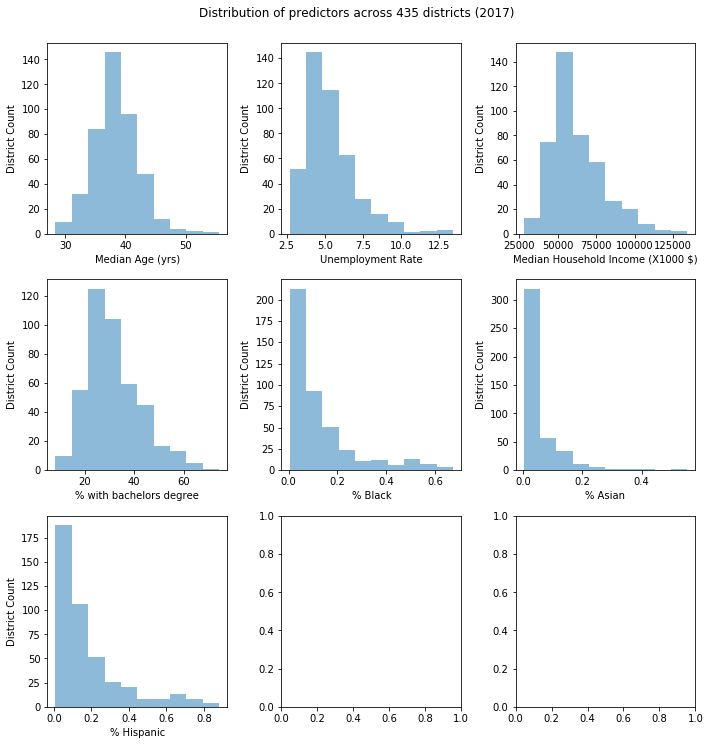

In [39]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
ax = ax.flatten()
fig.suptitle('Distribution of predictors across 435 districts (2017)', y=1.03)
labels=['Median Age (yrs)', 'Unemployment Rate', 'Median Household Income (X1000 $)',
        '% with bachelors degree', 
        '% Black', '% Asian', '% Hispanic']

for i, col_i in enumerate([2, 3, 4, 5, 13, 14, 15]):
    ax[i].hist(SE_data_merged.iloc[:,col_i].dropna().astype(float), alpha=0.5)
    ax[i].set_ylabel('District Count')
    ax[i].set_xlabel(labels[i])
    
plt.tight_layout()


In [40]:
## This data applies for the 2018 election (it is the most recent)

SE_data_merged['year'] = 2018

In [41]:
## Merging in current socioeconomic data -- will do 
## when we have more data than 2018
# combined_data = pd.merge(merged_elections_ideology, 
#                         SE_data_merged,
#                         on = ["dist_id", "year"],
#                         how = "left")

In [42]:
## Data for 2000 - 2017
unemp_df = pd.read_csv(local_data_folder + 
                       "unemployment_2000-2017_imputed_district_average.csv")

In [43]:
unemp_df[:5]

,dist_id,year,unemployment
0,AK_1,2000,7.8
1,AZ_1,2000,5.2
2,AZ_4,2000,5.0
3,CA_5,2000,7.4
4,CA_6,2000,3.3


In [44]:
## Merging in unemployment data
combined_data = pd.merge(merged_elections_ideology, 
                        unemp_df,
                        on = ["dist_id", "year"],
                        how = "left")
combined_data.drop_duplicates(inplace = True)
combined_data.to_csv(local_data_folder + "combined_data.csv",
                    index = False)

In [45]:
combined_data[10:15]

,year,dist_id,dem_vote_share,dem_vote_share_2018,dem_won_2018,congress,icpsr,nominate_dim1,nominate_dim2,nokken_poole_dim1,nokken_poole_dim2,age,dem_incumbent,unemployment
10,2000,AK_1,0.192064,0.458323,0.0,106.0,14066.0,0.279,0.014,0.295,0.181,67.0,0,7.8
11,2002,AK_1,0.188273,0.458323,0.0,107.0,14066.0,0.279,0.014,0.383,0.215,69.0,0,9.6
12,2004,AK_1,0.239302,0.458323,0.0,108.0,14066.0,0.279,0.014,0.353,0.142,71.0,0,9.4
13,2006,AK_1,0.414254,0.458323,0.0,109.0,14066.0,0.279,0.014,0.367,-0.047,73.0,0,9.4
16,2008,AK_1,0.472837,0.458323,0.0,110.0,14066.0,0.279,0.014,0.291,0.269,75.0,0,7.7


In [46]:
## Dropping some columns for the scatter matrix
cols_to_drop_for_scatter = ['dist_id', 'congress', 'icpsr']

to_scatter_df = combined_data.drop(cols_to_drop_for_scatter,
                                   axis = 1,
                                  inplace = False)

Below, we see a scatter matrix for all of the predictors in the dataset. One interesting aspect of the scatter matrix is that the ideological measures are split at 0.5 -- that is, there are few observations at the median of the distribution. This may prove problematic, as voting records are likely highly collinear with the incumbent's party. Interestingly, however, there is a high level of variance between ideological scores and the ultimate democratic vote share, indicating that incumbent ideology is a good, though not perfect, predictor of the election outcome. 

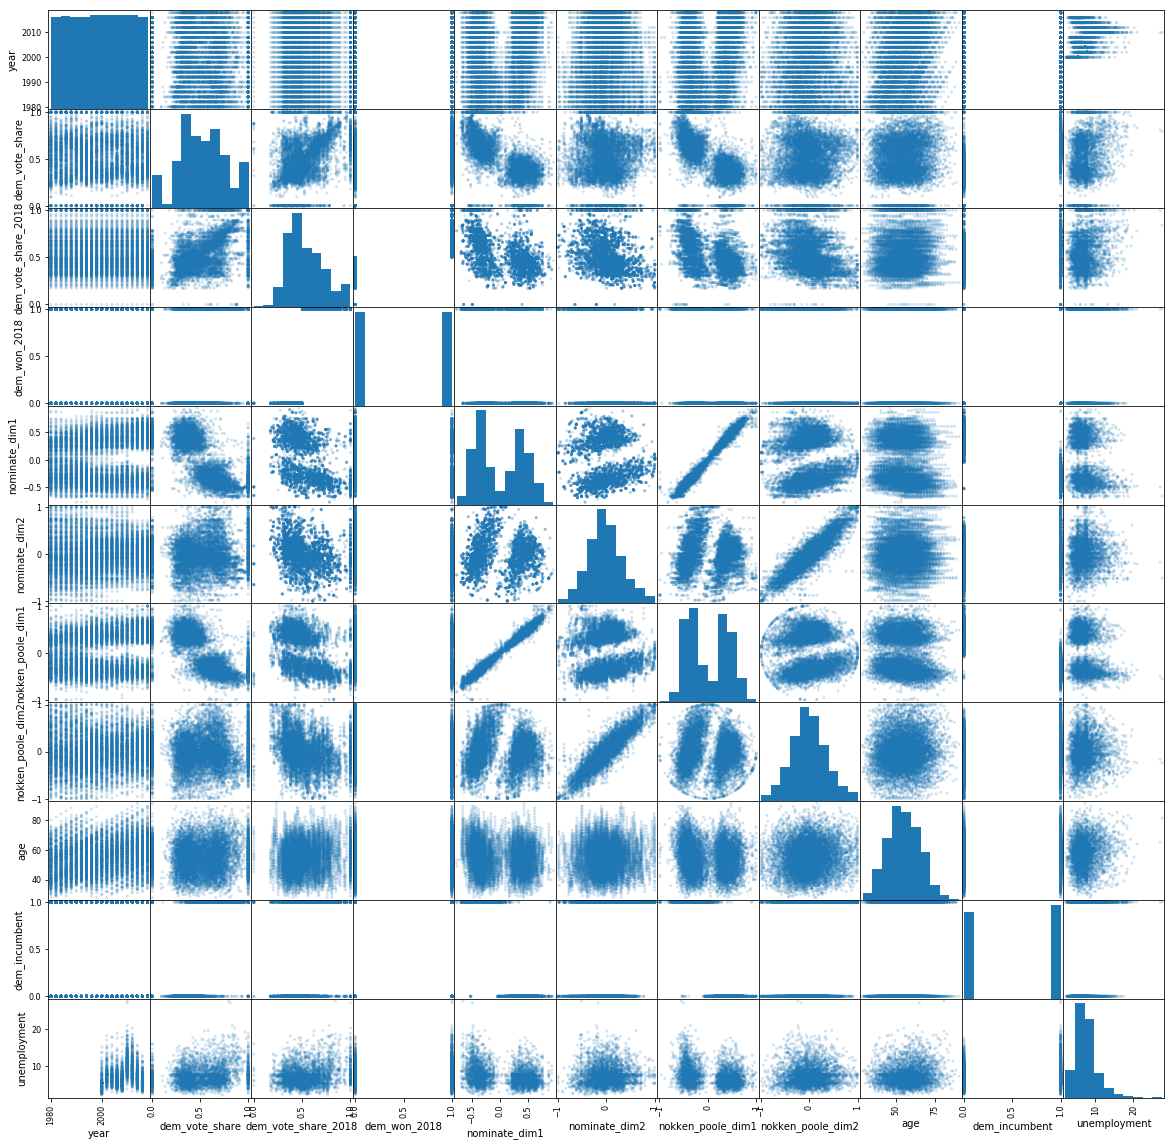

In [47]:
pd.plotting.scatter_matrix(to_scatter_df, alpha = 0.2,
                           figsize = (20,20))
plt.savefig(local_data_folder + "scatter_matrix.png");

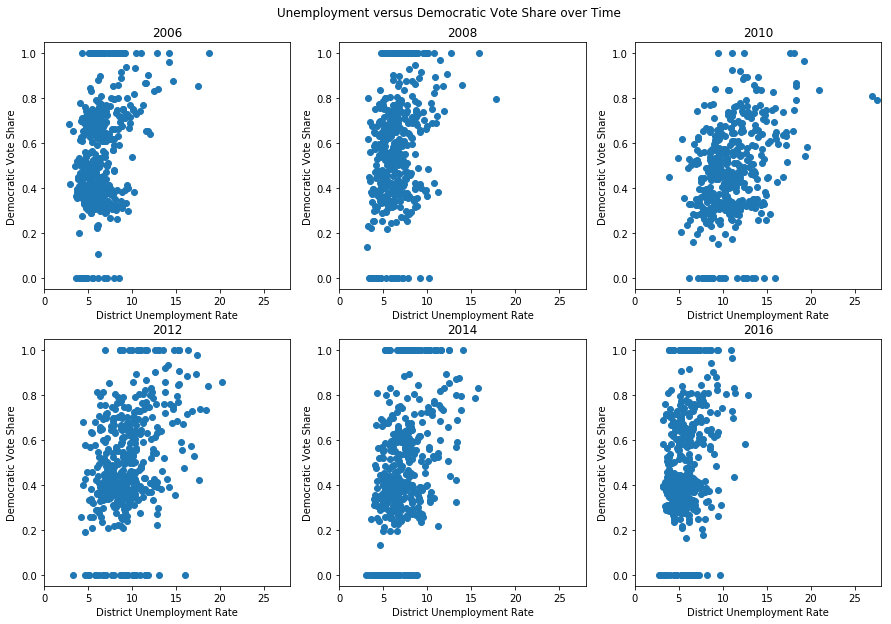

In [48]:
years_no_NA_unemp = np.arange(2006, 2017, 2)

col_n, row_n = 3, 2

fig, ax  = plt.subplots(nrows=row_n, ncols=col_n, figsize=(5*col_n,5*row_n))
# plt.tight_layout()
ax = ax.flatten()
fig.suptitle("Unemployment versus Democratic Vote Share over Time", y = 0.93)
for i, year_i in enumerate(years_no_NA_unemp):
    this_year_df = combined_data[combined_data.year == year_i]
    ax[i].plot(this_year_df['unemployment'],
                 this_year_df['dem_vote_share'], "o")
    ax[i].set_title(year_i)
    ax[i].set_xlim(0, 28)
    ax[i].set_ylabel('Democratic Vote Share')
    ax[i].set_xlabel("District Unemployment Rate")
    
plt.show();

In [52]:
combined_data.to_csv(local_data_folder + "combined_data.csv",
                     index=False)

Interestingly, we see above that the relationship between district-level unemployment and the percent of the vote that the Democratic candidate obtains might not be linear. Particularly, when there is greater variation in unemployment, the apparent relationship between unemployment and greater success for Democratic candidates is stronger. We see this in particular in comparing the elections in 2010 and 2016: in 2010, unemployment surpassed 25% in two districts, while it was no higher than 15% in 2016. These scatterplots suggest that we should include a measure of variation in nationwide unemployment and the unemployment rate itself, or that especially high unemployment rates may be outliers that could bias our results. In any case, care should be taken with these data. 

Below, we fit a basic logistic model to predict the 2016 election outcomes (the 2018 outcomes are not yet available in full, as discussed above). We base this model solely on the election outcomes in the district since 1980. Impressively, this baseline model already performs fairly well. However, future models that incorporate more covariates will likely do better. 

In [ ]:
# Fit logistic regression on training data 
data_to_fit = combined_data.drop(cols_to_drop_for_train, axis = 1,
                                inplace = False)
data_to_fit = data_to_fit.dropna(inplace = False)

In [350]:
# Fit logistic regression on training data 

## Can't predict 2016 results with 2016 results...
x_train = data_to_fit[data_to_fit.year < 2016]
y_train = x_train.dem_won_2016.values


train_test_split(bikes_main, test_size = 0.2,
                 random_state = 53029,
                 stratify=bikes_main['month'])


LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
logreg1 = LogisticRegression(C=100000)
logreg1.fit(x_train.dem_vote_share.values.reshape(-1, 1),
            y_train)

In [361]:


# Make Prediction and check the accuracy
y_train_probs=(logreg1.predict_proba(x_train.dem_vote_share\
                                     .values.reshape(-1, 1)))

train_accuracy = logreg1.score(x_train.dem_vote_share\
                               .values.reshape(-1, 1),
                            y_train)*100

print('Accuracy of logistic regression classifier on train set: ',
      np.round(train_accuracy, 2), "%", sep = "")


Accuracy of logistic regression classifier on train set: 82.83%


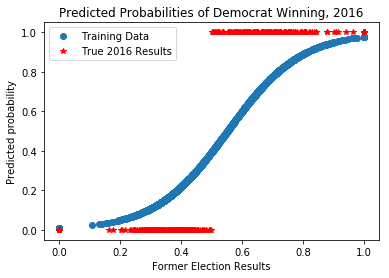

In [376]:
## True outcomes:
x_train_true = data_to_fit[data_to_fit.year == 2016]['dem_vote_share'].values
y_train_true = data_to_fit[data_to_fit.year == 2016]['dem_won_2016'].values

# Plot predicted probabilities

plt.plot(x_train.dem_vote_share.values,
         y_train_probs[:,1],'o',label='Training Data')
plt.plot(x_train_true, y_train_true, "*", color = "red",
        label = "True 2016 Results")
plt.xlabel('Former Election Results')
plt.ylabel('Predicted probability')
plt.title('Predicted Probabilities of Democrat Winning, 2016')
plt.legend()

plt.show();

In [419]:
cols_to_drop_for_train = ['dist_id', 'congress', 'icpsr']

# Fit logistic regression on training data 
data_to_fit = combined_data.drop(cols_to_drop_for_train, axis = 1,
                                inplace = False)
data_to_fit = data_to_fit.dropna(inplace = False)

## Can't predict 2016 results with 2016 results...
data_2016 = data_to_fit[data_to_fit.year < 2016]
y_train = data_2016.dem_won_2016.values
x_train = data_2016.drop('dem_won_2016', axis = 1, inplace = False)

x_train[:5]

,year,dem_vote_share,nominate_dim1,nominate_dim2,nokken_poole_dim1,nokken_poole_dim2,age,dem_incumbent,unemployment
10,2000,0.192064,0.279,0.014,0.295,0.181,67.0,0,7.8
11,2002,0.188273,0.279,0.014,0.383,0.215,69.0,0,9.6
12,2004,0.239302,0.279,0.014,0.353,0.142,71.0,0,9.4
13,2006,0.414254,0.279,0.014,0.367,-0.047,73.0,0,9.4
16,2008,0.472837,0.279,0.014,0.291,0.269,75.0,0,7.7


In [400]:
mod1 = LogisticRegression(C=100000)
mod1.fit(x_train, y_train)
# Make Prediction and check the accuracy
y_train_probs=(mod1.predict_proba(x_train))

train_accuracy = mod1.score(x_train,y_train)*100

print('Accuracy of logistic regression classifier on the whole training set: ',
      np.round(train_accuracy, 2), "%", sep = "")

Accuracy of logistic regression classifier on the whole training set: 83.33%


## MORE COMPLEX MODEL

In [401]:
## Incorporating power and interaction terms

def add_power_terms(df, continuous_colnames, degree):
    if degree > 2 & degree % 1 == 0:
        for i in range(2, degree+1):
            for col in continuous_colnames:
                new_colname = col+"^"+str(i)
                df[new_colname] = df[col]**i
    else:
        if degree == 1:
            return(df)
        else:
            print("Invalid degree term")
    return(df)

def add_interaction_terms(df, continuous_colnames):
    binary_colnames = df.columns.difference(continuous_colnames)
    ## removing power terms
    binary_colnames = [x for x in binary_colnames if "^" not in x]
    
    for continuous_colname in continuous_colnames:
        for binary_colname in binary_colnames:
            interaction_colname = continuous_colname + "*" + binary_colname
            df[interaction_colname] = df[continuous_colname]*df[binary_colname]
    return(df)


In [420]:
## Can't predict 2016 results with 2016 results...
data_2016 = data_to_fit[data_to_fit.year < 2016]
y_train = data_2016.dem_won_2016.values
x_train = data_2016.drop('dem_won_2016', axis = 1, inplace = False)

x_train[:5]

,year,dem_vote_share,nominate_dim1,nominate_dim2,nokken_poole_dim1,nokken_poole_dim2,age,dem_incumbent,unemployment
10,2000,0.192064,0.279,0.014,0.295,0.181,67.0,0,7.8
11,2002,0.188273,0.279,0.014,0.383,0.215,69.0,0,9.6
12,2004,0.239302,0.279,0.014,0.353,0.142,71.0,0,9.4
13,2006,0.414254,0.279,0.014,0.367,-0.047,73.0,0,9.4
16,2008,0.472837,0.279,0.014,0.291,0.269,75.0,0,7.7


In [424]:
continuous_cols = [x for x in x_train.columns if x != 'dem_incumbent']

In [425]:
from sklearn.preprocessing import MinMaxScaler

In [426]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(x_train)
x_train_scaled = pd.DataFrame(min_max_scaler.transform(x_train))
x_train_scaled.columns = x_train.columns
x_train_scaled[:5]

,year,dem_vote_share,nominate_dim1,nominate_dim2,nokken_poole_dim1,nokken_poole_dim2,age,dem_incumbent,unemployment
0,0.000000,0.192064,0.603254,0.50502,0.642159,0.588799,0.619048,0.0,0.221344
1,0.142857,0.188273,0.603254,0.50502,0.687404,0.605954,0.650794,0.0,0.292490
2,0.285714,0.239302,0.603254,0.50502,0.671979,0.569122,0.682540,0.0,0.284585
3,0.428571,0.414254,0.603254,0.50502,0.679177,0.473764,0.714286,0.0,0.284585
4,0.571429,0.472837,0.603254,0.50502,0.640103,0.633199,0.746032,0.0,0.217391


In [427]:
x_train_poly = add_power_terms(x_train_scaled, continuous_cols, 5)
x_train_poly = add_interaction_terms(x_train_poly, continuous_cols)

In [428]:
x_train_poly[:5]

,year,dem_vote_share,nominate_dim1,nominate_dim2,nokken_poole_dim1,nokken_poole_dim2,age,dem_incumbent,unemployment,year^2,...,age^5,unemployment^5,year*dem_incumbent,dem_vote_share*dem_incumbent,nominate_dim1*dem_incumbent,nominate_dim2*dem_incumbent,nokken_poole_dim1*dem_incumbent,nokken_poole_dim2*dem_incumbent,age*dem_incumbent,unemployment*dem_incumbent
0,0.000000,0.192064,0.603254,0.50502,0.642159,0.588799,0.619048,0.0,0.221344,0.000000,...,0.090912,0.000531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.142857,0.188273,0.603254,0.50502,0.687404,0.605954,0.650794,0.0,0.292490,0.020408,...,0.116739,0.002141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.285714,0.239302,0.603254,0.50502,0.671979,0.569122,0.682540,0.0,0.284585,0.081633,...,0.148129,0.001867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.428571,0.414254,0.603254,0.50502,0.679177,0.473764,0.714286,0.0,0.284585,0.183673,...,0.185934,0.001867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.571429,0.472837,0.603254,0.50502,0.640103,0.633199,0.746032,0.0,0.217391,0.326531,...,0.231093,0.000486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [429]:
mod2 = LogisticRegression(C=100000)
mod2.fit(x_train_poly, y_train)
# Make Prediction and check the accuracy
y_train_probs=(mod2.predict_proba(x_train_poly))

train_accuracy = mod2.score(x_train_poly,y_train)*100

print('Accuracy of logistic regression classifier on the whole training set: ',
      np.round(train_accuracy, 2), "%", sep = "")

Accuracy of logistic regression classifier on the whole training set: 84.25%
